In [2]:
#default_exp metrics

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Dev comments

- [X] TODO: make entropy estimator with KDE
- [X] TODO: make quantile func
- [ ] TODO: make Gaussian Mixture entropy estimation
- [ ] TODO: make multicore sampling for kde

# Imports -

In [5]:
#export
from tqdm.notebook import tqdm

import numpy as np
from sklearn.metrics import pairwise
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

from skdensity.core.random_variable import KDE, RandomVariable
from skdensity.utils import (
    draw_from,
    _fix_one_sample_2d, _fix_one_dist_2d, _fix_dist_1d,
    _fix_X_1d, _assert_dim_3d, _assert_dim_1d, _assert_dim_2d, _fix_one_dist_1d,
    _add_n_samples_axis
)

# Test data

We are going to test utils using the following data:

In [6]:
#documentation imports
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [7]:
#data
y_dists = np.hstack([np.random.randn(10,200,2), np.random.randn(10,200,2)+5])
y_true = np.hstack([np.random.randn(10,1,2)])

y_dists_1d = np.random.randn(10,200,1)
y_true_1d = np.random.randn(10,1,1)

# `Metrics` -

In [8]:
#export
def _check_kde_metrics_input(y_true, y_dists, frac):
    '''
    preprocesses inputs for kde metrics calculation
    '''
    y_dists = _assert_dim_3d(y_dists)

    if len(y_true.shape) <= 3:
        assert y_true.shape[0] == y_dists.shape[0], f'y_true dim 0 should be equal y_dists dim 0, got {y_true.shape[0]} and {y_dists.shape[0]}'
    else:
        raise Exception(f'y_true dims should less or equal to 3, got {len(y_true.shape)}')

    y_true = _fix_one_sample_2d(y_true)

    assert y_true.shape[-1] == y_dists.shape[-1], f'y_true and y_dists last axis (n_dims) should be equal. got {y_true.shape[-1]} and {y_dists.shape[-1]}'

    idxs = np.arange(y_true.shape[0])
    idxs = draw_from(idxs, frac)

    y_dists = y_dists[idxs]
    y_true = y_true[idxs]
    return y_true, y_dists

## `kde_entropy`

In [9]:
#export
def kde_entropy(data, sample_size = 200, frac = 1.0, progress_bar = False, **kde_kwargs):
    '''
    Calculates the entropy of multiple continuous distributions. entropy equals np.mean(-np.log(p(x)))
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    data = _fix_one_dist_2d(data)
    data = _assert_dim_3d(data)
    kde = KDE(**kde_kwargs)
    data = draw_from(data, frac)
    if progress_bar:
        return np.array([kde.fit(d).entropy(sample_size = sample_size) for d in tqdm(data)])
    else:
        return np.array([kde.fit(d).entropy(sample_size = sample_size) for d in data])

`kde_entropy` estimates a distribution of an aribtrary dimension random variable using kernel density estimation and calculates its entropy

In [10]:
kde_entropy(y_dists,frac = 0.05, implementation = 'sklearn')

array([2.76527246])

In [11]:
%%timeit
kde_entropy(y_dists, implementation = 'sklearn', bw = 'ISJ')

440 ms ± 41.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## `kde_likelihood`

In [12]:
#export
def kde_likelihood(y_true,y_dists, frac = 1.0, progress_bar = False,**kde_kwargs):
    '''
    Calculates the likelihood of y_true in kde estimation of samples
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    y_true, y_dists = _check_kde_metrics_input(y_true, y_dists, frac)

    kde = KDE(**kde_kwargs)
    if progress_bar:
        likelihoods = np.array([kde.fit(y_dists[i]).evaluate(y_true[i]) for i in tqdm([*range(y_dists.shape[0])])])
    else:
        likelihoods =  np.array([kde.fit(y_dists[i]).evaluate(y_true[i]) for i in range(y_dists.shape[0])])

    return _fix_dist_1d(likelihoods)

`kde_likelihood` Calculates the likelihood of y_true in kde estimation of samples

In [13]:

kde_likelihood(np.random.randn(10, 3 ,2),y_dists, frac = 0.4).shape

(4, 3, 1)

In [14]:
%%timeit
kde_likelihood(y_true,y_dists, implementation = 'scipy', bw = 'scott')

The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached.
83.2 ms ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## relative_likelihood

In [15]:
def relative_likelihood():
    '''
    returns the relative likelihood of a point compared to the distribution
    likelhood(point)/mean(likleihood(dist))
    '''
    raise NotImplementedError

## `ppf`

In [16]:
#export
def ppf(percentiles, y_dists):
    '''
    returns the percent point function for given y_dists and percentiles
    expected dims:
    percentiles: (n_dists, n_points)
    y_dists: (n_dists, n_samples, dims)
    '''
    assert len(percentiles.shape) == 2, f'percentiles should have 2 dimensions: (n_dists, n_percentiles), got {len(percentiles.shape)}'
    assert len(y_dists.shape) == 3, f'y_dists should have 3 dimensions: (n_dists, n_samples, n_dims), got {len(y_dists.shape)}'
    assert percentiles.shape[0] == y_dists.shape[0], f'percentiles n_dists should be equal y_dists n_dists. got {percentiles.shape[0]} and {y_dists.shape[0]}'
    values = np.array([np.quantile(y_dists[i], percentiles[i], axis = 0) for i in range(y_dists.shape[0])])
    return _fix_one_sample_2d(values)

(10, 100, 2)

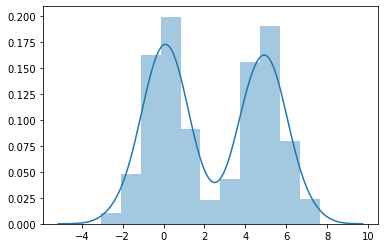

In [17]:
sns.distplot(ppf(np.random.random((10,100)),y_dists)[:,:,0])
ppf(np.random.random((10,100)),y_dists).shape

## `cdf`

In [18]:
#export
def _cdf(dist):
    '''
    returns the cdf of each element in a 1d array (distribution)
    '''
    _assert_dim_1d(dist)
    temp = dist.argsort()
    return np.arange(len(dist))[temp.argsort()]/(len(dist)-1)

def cdf(y_dists):
    '''
    returns the cdf of each element in each 1d dist
    '''
    y_dists = _assert_dim_3d(y_dists)
    arr = np.zeros(y_dists.shape)
    for dist in np.arange(y_dists.shape[0]):
        for dim in np.arange(y_dists.shape[-1]):
            arr[dist,:,dim] = _cdf(y_dists[dist,:,dim])

    return arr

In [19]:
%timeit cdf(y_dists)

1.31 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## `quantile`

In [20]:
#export
def quantile(y_true, y_dists):
    '''
    checks in which quantile lies y_true, given the predicted distribution
    y_true shape should be of shape (n_dists, n_samples ,n_dims)
    y_dists_should be of shape (n_dists, n_samples, n_dims)
    '''

    y_true = _fix_one_sample_2d(y_true)
    y_dists = _assert_dim_3d(y_dists)
    assert y_true.shape[0] == y_dists.shape[0], 'number of dists should be the same as number of points'

    values = []
    for i in range(y_true.shape[0]):
        values.append([])
        for j in range(y_true.shape[1]):
            values[i].append((y_true[i,j].T >= y_dists[i]).mean(axis = 0))

    return _fix_one_sample_2d(np.array(values))

`quantile` checks the quantile of each dimension of an observation `y_true` given an empirical distribution `y_dists`

In [21]:
quantile(y_true, y_dists)

array([[[0.1525, 0.2275]],

       [[0.345 , 0.1025]],

       [[0.305 , 0.39  ]],

       [[0.1875, 0.4575]],

       [[0.3225, 0.31  ]],

       [[0.4675, 0.1275]],

       [[0.4075, 0.2925]],

       [[0.26  , 0.3775]],

       [[0.24  , 0.3425]],

       [[0.1425, 0.3075]]])

In [22]:
%%timeit
quantile(y_true, y_dists)

338 µs ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## `kde_quantile`

In [26]:
#export
def kde_quantile(y_true, y_dists, frac = 1.0, progress_bar = False, **kde_kwargs):
    '''
    fits a kde in a distribution and returns the quantile that a point in y_true belongs to in that distribution
    '''
    y_true, y_dists = _check_kde_metrics_input(y_true, y_dists, frac = 1)
    kde = KDE(**kde_kwargs)
    if progress_bar:
        return np.array([kde.fit(y_dists[i]).cdf(y_true[i]) for i in tqdm([*range(len(y_dists))])])
    else:
        return np.array([kde.fit(y_dists[i]).cdf(y_true[i]) for i in range(len(y_dists))])

`kde_quantile` fits a kde to each dist in `y_dists` and checks the ppf of `y_true` rowwise

In [27]:
kde_quantile(y_true, y_dists)

array([[[[0.137, 0.194]]],


       [[[0.347, 0.104]]],


       [[[0.308, 0.394]]],


       [[[0.175, 0.435]]],


       [[[0.321, 0.305]]],


       [[[0.437, 0.111]]],


       [[[0.411, 0.299]]],


       [[[0.29 , 0.388]]],


       [[[0.249, 0.356]]],


       [[[0.155, 0.303]]]])

In [28]:
%%timeit
kde_quantile(y_true, y_dists)

41.6 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## `quantile_sklearn`

In [29]:
#export
def quantile_sklearn(y_true, y_dists):
    '''checks in which quantile lies y_true, given the predicted distribution, using skleaerns QuantileTransformer'''
    y_true, y_dists = _check_kde_metrics_input(y_true, y_dists, frac = 1)
    return np.array([QuantileTransformer().fit(y_dists[i]).transform(y_true[i]) for i in range(y_dists.shape[0])])

`quantile_sklearn` does the same as `quantile`, but with `sklearn`s `QuantileTransformer`

In [30]:
quantile_sklearn(y_true, y_dists)

array([[[0.15065424, 0.2268348 ]],

       [[0.34338763, 0.10048143]],

       [[0.30430057, 0.3890906 ]],

       [[0.18600675, 0.45821855]],

       [[0.32124706, 0.30874167]],

       [[0.46804925, 0.12577438]],

       [[0.40809728, 0.29131635]],

       [[0.25918572, 0.37665702]],

       [[0.23969778, 0.34215038]],

       [[0.14050299, 0.30788407]]])

In [31]:
%%timeit
quantile_sklearn(y_true, y_dists)

9.71 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `theoretical_entropy`

In [37]:
#export
def theoretical_entropy(data, dist = 'norm'):
    '''
    returns the entropy of the maximum likelihood estiation of `dist` given `data`
    dist should be one dimensional for cases when `dist` != 'kde'
    '''
    data = _assert_dim_3d(data)
    return np.array([RandomVariable().fit(data, dist).entropy(dist) for d in data])

`theoretical_entropy` returns the entropy of the maximum likelihood estiation of `dist` given `data`
    dist should be one dimensional for cases when `dist` != 'kde'

In [39]:
theoretical_entropy(y_dists_1d, dist = 'norm')

array([1.43552615, 1.43552615, 1.43552615, 1.43552615, 1.43552615,
       1.43552615, 1.43552615, 1.43552615, 1.43552615, 1.43552615])

In [40]:
%%timeit
theoretical_entropy(y_dists_1d, dist = 'norm')

8.44 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `marginal_variance`

In [41]:
#export
def marginal_variance(data):
    '''
    Calculates the variance for each dimension (marginal) of multiple distributions
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    data = _assert_dim_3d(data)
    return data.var(axis = -2)

`marginal_variance` Calculates the variance for each dimension (marginal) of multiple distributions
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)

In [42]:
marginal_variance(y_dists)

array([[6.86687699, 7.1531277 ],
       [7.35160203, 7.10943149],
       [7.04696018, 6.93981836],
       [7.10407335, 7.14802336],
       [7.22071499, 7.30302201],
       [7.23956112, 7.24550096],
       [7.62341841, 7.12720148],
       [7.70847659, 6.64648609],
       [7.42569946, 7.11027344],
       [7.37377854, 7.11825858]])

## `covariance_matrix` 

In [43]:
#export
def covariance_matrix(data):
    '''
    Calculates the variance for each dimension (marginal) of multiple distributions
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    raise NotImplementedError

## `bimodal_split`

In [47]:
#export    
def bimodal_split(data, filter_size = 3, lb = 0.1,ub = 0.9):
    '''
    reutrns siplitting point of single distribution in two according to the highest value of the derivative of cpdf
    '''

    _assert_dim_1d(data)
    filter_size = int(np.ceil(filter_size)) if filter_size >= 1 else int(max(1,np.ceil(data.shape[0]*filter_size)))
    data.sort()
    data = filter_borders(data,lb,ub)
    diff = np.diff(data)
    v = np.ones(filter_size)/filter_size
    diff = np.convolve(a = diff,v = v, mode = 'same')
    argmax = np.argmax(diff)
    split_point = (data[min(data.shape[0] - 1,argmax + filter_size)] + data[argmax])/2
    return split_point

`bimodal_split` reutrns siplitting point of single distribution in two according to the highest value of the derivative of cpdf

In [48]:
bimodal_split(y_dists[0,:,0], filter_size = 3, lb = 0.1,ub = 0.9)

2.5980453840797124

In [49]:
%%timeit
bimodal_split(y_dists[0,:,0], filter_size = 3, lb = 0.1,ub = 0.9)

28 µs ± 531 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## `agg_smallest_distance`

In [50]:
#export
def agg_smallest_distance(data, agg_func = np.mean):
    '''
    returns the agregate (defined by agg_func) distance of each point and their closest neighbor
    recieves array of shape (n_dists,n_samples, n_dims) and reutrns array of shape (n_dists, n_dims)
    weights should be of shape (n_dists, n_samples, n_dims)
    '''
    _assert_dim_3d(data)
    data = np.sort(data, axis = 1)
    data = np.diff(data, axis = 1)
    results = agg_func(data, axis = 1)
    return results

def cov_smallest_distance(data, agg_func = np.mean):
    '''
    returns the covariance matrix of the distances of each point and their closest neighbor
    recieves array of shape (n_dists,n_samples, n_dims) and reutrns array of shape (n_dists, n_dims)
    '''
    _assert_dim_3d(data)
    data = np.sort(data, axis = 1)
    data = np.diff(data, axis = 1)
    results = np.array([np.cov(i, rowvar = False) for i in data])
    return results

In [51]:
bw = agg_smallest_distance(y_dists[0:1], np.mean, weights = np.ones(y_dists[0:1].shape)).max()

AssertionError: shape of weights should match data wieghts. got (1, 400, 2) and (1, 399, 2)

0.029043275439543447


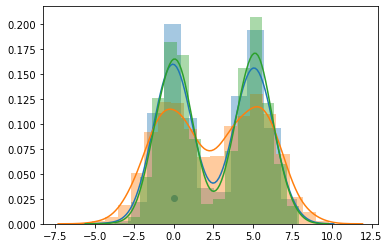

In [33]:
print(bw)
sns.distplot(y_dists[0])
sns.distplot(KDE(bw = 'scott', implementation = 'sklearn').fit(y_dists[0]).sample(1000))
sns.distplot(KDE(bw = bw, implementation = 'sklearn').fit(y_dists[0]).sample(1000))

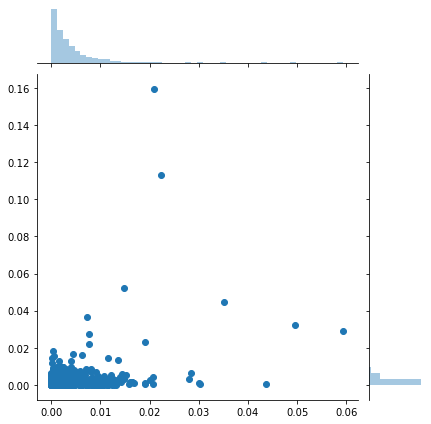

In [37]:
from sklearn.datasets import make_moons
moons, _ = make_moons(1000, noise = 0.2)
moons = moons.reshape(1, *moons.shape)
cov_smallest_distance(moons)

dists = np.diff(np.sort(moons, axis = 1), axis = 1)
sns.jointplot(dists[0,:,0],dists[0,:,1])


## `mad` 

In [676]:
#export
def mad(data):
    '''
    calculates mean average deviance (a robust version of standard deviation)
    '''
    np.median(np.absolute(data - np.median(data)))
    pass

## `bimodal_variance` 

In [8]:
#export
def bimodal_variance(data, filter_size = 0.05, lb = 0.1,ub = 0.9):
    '''
    returns weighted marginal variance of splitted data in two according to the highest value of the derivative of cpdf
    returns a variance array of shape (n_dists, n_dims)
    '''
    data = _assert_dim_3d(data)
    #make split point
    #GENERALIZE FOR MULTIDIM
    mses = []
    for dist in range(data.shape[0]):
        mses.append([])
        for dim in range(data.shape[2]):
            d = data[dist,:,dim]
            split_point = bimodal_split(d, filter_size, lb ,ub)
            arr1, arr2 = d[d >= split_point], d[d < split_point]
            mses[dist].append((arr1.shape[0]*(arr1.var()) + arr2.shape[0]*(arr2.var()))/d.shape[0])
    #average variance
    return np.array(mses)

`bimodal_variance` returns weighted variance of splitted data in two according to the highest value of the derivative of cpdf
    returns a variance array of shape (n_dists, n_dims)

In [9]:
bimodal_variance(y_dists, filter_size = 0.05, lb = 0.1,ub = 0.9)

NameError: name 'y_dists' is not defined

In [684]:
%%timeit
bimodal_var(y_dists, filter_size = 0.05, lb = 0.1,ub = 0.9)

1.31 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## `gaussian_distance_entropy`

In [ ]:
#export
def gaussian_distance_entropy(data):
    '''
    calculates the entropy of the distribution of distances from centroid of points in dist, assuming normal distribution
    '''
    return -np.log(expected_distance_gaussian_likelihood(data))

## `expected_distance_gaussian_likelihood`

In [ ]:
#export
def expected_distance_gaussian_likelihood(data):
    '''
    calculates the expected likelihood of the distances from centroid of samples in distributions in dist
    input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    dist = _assert_dim_3d(data)
    return np.array([distance_gaussian_likelihood(d).mean() for d in data])

## `distance_gaussian_likelihood`

In [600]:
#export
def distance_gaussian_likelihood(data):
    '''
    calculates the expected likelihood of the distances from the centroid of samples in dist
    '''
    centroid = data.mean(axis = 0).reshape(1,-1)
    distances =  pairwise.euclidean_distances(data, centroid).flatten()
    distance_std = distances.std()
    if distance_std == 0:
        return 1
    z = (distances - distances.mean())/distance_std
    return 1/(distance_std*np.pi**(1/2))*np.exp(-1/2*z**2)

# Helping functions - 

## `make_outlier_filter`

In [687]:
#export
def make_outlier_filter(data, lb = 25, ub = 75, c = 1):
    a = np.array(data)
    upper_quartile = np.percentile(a, ub)
    lower_quartile = np.percentile(a, lb)
    iqr = (upper_quartile - lower_quartile) * c
    lb = lower_quartile - iqr
    ub = upper_quartile + iqr
    filter_ = np.zeros(a.shape)
    filter_[(a >= lb) & (a <= ub)] = 1
    return filter_

## `filter_borders`

In [46]:
#export
def filter_borders(data, lb = 0.05, ub = 0.95):
    lb = int(len(data)*lb)
    ub = int(len(data)*ub)
    return data[lb:ub]

#def distance_log_variance(dist):
#    '''variance of the distances of points to centroid of distribution'''
#    centroid = dist.mean(axis = 0).reshape(1,-1)
#    distances =  pairwise.euclidean_distances(dist, centroid).flatten()
#    return distances.var()

# Export -

In [225]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.
Converted 04_metrics.ipynb.
Converted 05_neighbors.ipynb.
Converted 06_kde_baesyan_nets.ipynb.
Converted index.ipynb.


In [22]:
#hide
from nbdev.showdoc import show_doc
show_doc(kde_entropy)

<h4 id="kde_entropy" class="doc_header"><code>kde_entropy</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>kde_entropy</code>(**`data`**, **`sample_size`**=*`10000`*, **`bw`**=*`'ISJ'`*)

Calculates the entropy of multiple distributions
input should be of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)